In [307]:
from sympy import *
from dtumathtools import *
from IPython.display import Markdown
import networkx as nx
init_printing(use_latex="mathjax")
mdisplay = lambda x: display(Markdown(x))
nx_args={'with_labels':True, 'node_color':"white", 'edgecolors':"black", 'node_size':400}

# Grafteoretisk Modellering af Netværk

## Opgave 1

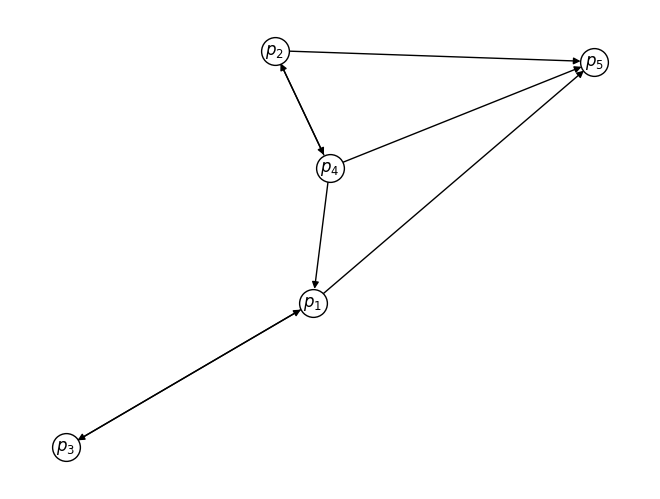

In [308]:
p1,p2,p3,p4,p5 = symbols('$p_1:6$')
V1 = {p1, p2, p3, p4, p5}
E1 = {(p1,p3), (p1,p5),(p2,p4),(p2,p5),(p3,p1),(p4,p1),(p4,p2),(p4,p5)}
W = nx.DiGraph()
W.add_nodes_from(V1, color="white")

W.add_edges_from(E1)
nx.draw(W,**nx_args)

## Opgave 2

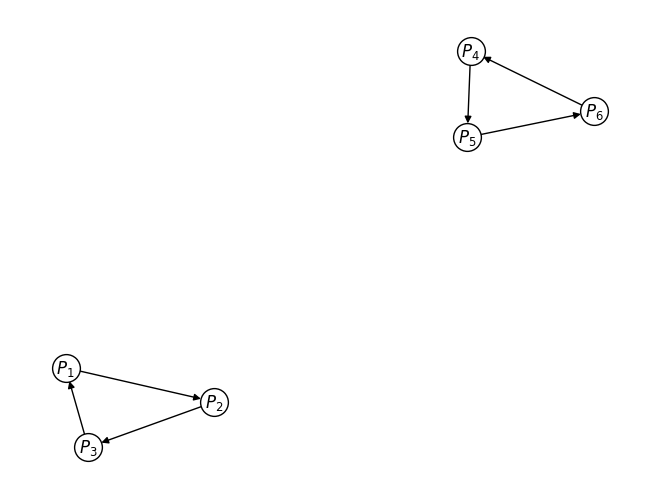

In [309]:
p1,p2,p3,p4,p5,p6 = symbols('$P_1:7$')
V2 = {p1, p2, p3, p4, p5, p6}
E2 = {(p1,p2), (p2,p3),(p3,p1),(p4,p5),(p5,p6),(p6,p4)}
W2 = nx.DiGraph()
W2.add_nodes_from(V2, color="white")

W2.add_edges_from(E2)
nx.draw(W2,**nx_args)

# Opgave 3
#

Jo flere komponenter der er i et netværk, jo svære bliver det at finde en specifik node. Faktisk er det helt umuligt at finde frem til en node i et komponent, hvis man er i et andet komponent til at begynde med. Der er altså ingen links fra den ene hjemmeside til den anden. 

##

In [310]:
W1 = {p1: {p3, p5}, p2: {p5, p4}, p3: {p1}, p4: {p1, p5, p2}, p5: {}}
W2 = {p1: {p2}, p2: {p3}, p3: {p1}, p4: {p5}, p5: {p6}, p6: {p4}}

Det kan tjekkes om en node i graphen ikke linker til andrer noder, ved at tjekke om nodens value i adjacency listen er den tomme mængde $\emptyset$

## Opgave 5

In [311]:
import numpy as np

# Input: n og k er ikke-negative heltal
# Output: web er en dictionary med n nøgler.
# Værdien af hver nøgle er en liste, der er en delmængde af nøglerne.
def make_web(n,k,kmin=0):
    assert(k < n), "k skal være mindre end n (da man ikke kan linke til sig selv)"
    assert(kmin <= k), "kmin skal være mindre end eller lig med k"
    keys = list(symbols(f"$p_0:{n}$")) 
    web = dict()
    
    for j in keys:
        numlinks = np.random.randint(kmin, k)
        key_choices = keys.copy()
        key_choices.remove(j)
        web[j] = set(np.random.choice(key_choices, numlinks))
    
    return web

print(make_web(4,3, 1))

{$p_0$: {$p_1$, $p_2$}, $p_1$: {$p_2$}, $p_2$: {$p_0$}, $p_3$: {$p_0$}}



## Opgave 6


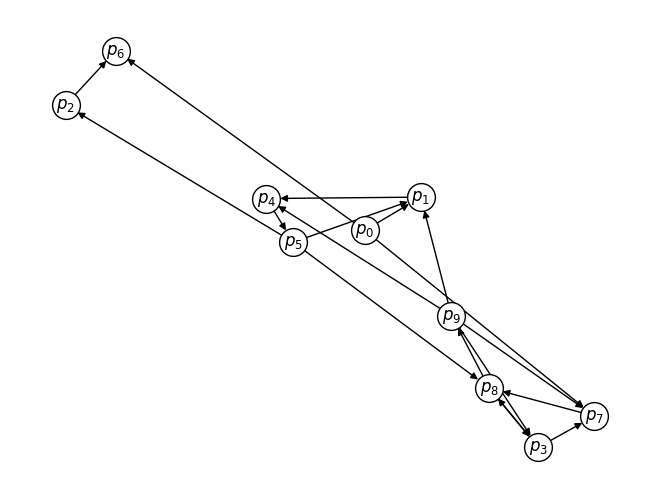

In [312]:
import matplotlib.pyplot as plt

def convert_to_nxgraph(web : dict):
    digraph = nx.DiGraph()
    digraph.add_nodes_from(web.keys())

    for page in web.keys():
        for link_to in web[page]:
            digraph.add_edge(page, link_to)

    return digraph

    # Input: netværk som dictionary
    # Output: Netværk visualiseret som graf
def visualize_graph(web : dict):
    
    digraph = convert_to_nxgraph(web)
    
    plt.figure()
    nx.draw(digraph, **nx_args)
    plt.plot()

visualize_graph(make_web(10, 5, 0))

# Link matricen og Random Surfer Modellen

## Opgave 7

In [313]:
def make_adjacency_matrix(graph):
    A = nx.adjacency_matrix(convert_to_nxgraph(graph))
    b = A.toarray().transpose()
    return b

In [314]:
W1 = {p1: {p3, p5}, p2: {p5, p4}, p3: {p1}, p4: {p1, p5, p2}, p5: {}}
display(Matrix(make_adjacency_matrix(W1)))




⎡0  0  1  1  0⎤
⎢             ⎥
⎢0  0  0  1  0⎥
⎢             ⎥
⎢1  0  0  0  0⎥
⎢             ⎥
⎢0  1  0  0  0⎥
⎢             ⎥
⎣1  1  0  1  0⎦

# Opgave 8

In [315]:
def make_link_matrix(graph: dict):

    adjacency_matrix : np.ndarray = make_adjacency_matrix(graph)

    n = adjacency_matrix.shape[0]
    link_matrix = np.zeros((n,n))
    
    for j in range(n):
        N = adjacency_matrix[:,j].sum()
        
        if N == 0:
            link_matrix[:,j] = 1 / n
            continue
            
        for i in range(n):
            if adjacency_matrix[i][j] == 1:
                link_matrix[i][j] = 1 / N
    
    return link_matrix
                

display(Matrix(make_link_matrix(W1)))


⎡0.0  0.0  1.0  0.333333333333333  0.2⎤
⎢                                     ⎥
⎢0.0  0.0  0.0  0.333333333333333  0.2⎥
⎢                                     ⎥
⎢0.5  0.0  0.0         0.0         0.2⎥
⎢                                     ⎥
⎢0.0  0.5  0.0         0.0         0.2⎥
⎢                                     ⎥
⎣0.5  0.5  0.0  0.333333333333333  0.2⎦

Matricerne har elementer samme sted, man tager antal 1-taller i hver søjle og sætter de tilsvarende elementer lig 1 / dette antal.
Hvis en søjle er en 0 vektor, sætter man alle elementer lig $\frac1N$

## Opgave 9

In [316]:
# Input: Et netværk som dictionary og en start side
# Output: Sandsynlighedsfordeling som dictionary for næste hjemmeside
def surf_step(web, page):
    
    distribution=dict()

    for link in web[page]:
        distribution[link] = 1 / len(web[page])


    return distribution

print(surf_step(W1, p1))

{$P_5$: 0.5, $P_3$: 0.5}


# Alexander

In [ ]:

link_matrix = Matrix(make_link_matrix(W2))
t=10





def testPRDum(page_index):
    x0 = Matrix([1,0,0,0,0])
    return link_matrix**t*x0[page_index]

def testPRGod(page_index):
    x0 = Matrix([0.2, 0.2, 0.2, 0.2, 0.2])[page_index]
    return link_matrix**t*x0

for i in range(5):
    mdisplay(f"$p_{i+1}$"
    display("Dum:")
    display(testPRDum(i))
    display("God:")
    display(testPRDum(i))
    display()









'$p_1$'

'Dum:'

⎡ 0    0   1.0   0    0    0 ⎤
⎢                            ⎥
⎢1.0   0    0    0    0    0 ⎥
⎢                            ⎥
⎢ 0   1.0   0    0    0    0 ⎥
⎢                            ⎥
⎢ 0    0    0    0    0   1.0⎥
⎢                            ⎥
⎢ 0    0    0   1.0   0    0 ⎥
⎢                            ⎥
⎣ 0    0    0    0   1.0   0 ⎦

'God:'

⎡ 0    0   1.0   0    0    0 ⎤
⎢                            ⎥
⎢1.0   0    0    0    0    0 ⎥
⎢                            ⎥
⎢ 0   1.0   0    0    0    0 ⎥
⎢                            ⎥
⎢ 0    0    0    0    0   1.0⎥
⎢                            ⎥
⎢ 0    0    0   1.0   0    0 ⎥
⎢                            ⎥
⎣ 0    0    0    0   1.0   0 ⎦

'$p_2$'

'Dum:'

⎡0  0  0  0  0  0⎤
⎢                ⎥
⎢0  0  0  0  0  0⎥
⎢                ⎥
⎢0  0  0  0  0  0⎥
⎢                ⎥
⎢0  0  0  0  0  0⎥
⎢                ⎥
⎢0  0  0  0  0  0⎥
⎢                ⎥
⎣0  0  0  0  0  0⎦

'God:'

⎡0  0  0  0  0  0⎤
⎢                ⎥
⎢0  0  0  0  0  0⎥
⎢                ⎥
⎢0  0  0  0  0  0⎥
⎢                ⎥
⎢0  0  0  0  0  0⎥
⎢                ⎥
⎢0  0  0  0  0  0⎥
⎢                ⎥
⎣0  0  0  0  0  0⎦

'$p_3$'

'Dum:'

⎡0  0  0  0  0  0⎤
⎢                ⎥
⎢0  0  0  0  0  0⎥
⎢                ⎥
⎢0  0  0  0  0  0⎥
⎢                ⎥
⎢0  0  0  0  0  0⎥
⎢                ⎥
⎢0  0  0  0  0  0⎥
⎢                ⎥
⎣0  0  0  0  0  0⎦

'God:'

⎡0  0  0  0  0  0⎤
⎢                ⎥
⎢0  0  0  0  0  0⎥
⎢                ⎥
⎢0  0  0  0  0  0⎥
⎢                ⎥
⎢0  0  0  0  0  0⎥
⎢                ⎥
⎢0  0  0  0  0  0⎥
⎢                ⎥
⎣0  0  0  0  0  0⎦

'$p_4$'

'Dum:'

⎡0  0  0  0  0  0⎤
⎢                ⎥
⎢0  0  0  0  0  0⎥
⎢                ⎥
⎢0  0  0  0  0  0⎥
⎢                ⎥
⎢0  0  0  0  0  0⎥
⎢                ⎥
⎢0  0  0  0  0  0⎥
⎢                ⎥
⎣0  0  0  0  0  0⎦

'God:'

⎡0  0  0  0  0  0⎤
⎢                ⎥
⎢0  0  0  0  0  0⎥
⎢                ⎥
⎢0  0  0  0  0  0⎥
⎢                ⎥
⎢0  0  0  0  0  0⎥
⎢                ⎥
⎢0  0  0  0  0  0⎥
⎢                ⎥
⎣0  0  0  0  0  0⎦

'$p_5$'

'Dum:'

⎡0  0  0  0  0  0⎤
⎢                ⎥
⎢0  0  0  0  0  0⎥
⎢                ⎥
⎢0  0  0  0  0  0⎥
⎢                ⎥
⎢0  0  0  0  0  0⎥
⎢                ⎥
⎢0  0  0  0  0  0⎥
⎢                ⎥
⎣0  0  0  0  0  0⎦

'God:'

⎡0  0  0  0  0  0⎤
⎢                ⎥
⎢0  0  0  0  0  0⎥
⎢                ⎥
⎢0  0  0  0  0  0⎥
⎢                ⎥
⎢0  0  0  0  0  0⎥
⎢                ⎥
⎢0  0  0  0  0  0⎥
⎢                ⎥
⎣0  0  0  0  0  0⎦